# Ejercicio 4: Modelo Probabilístico

### Nombre: Leonardo Quishpe

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [1]:
!pip install scikit-learn
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from sklearn.datasets import fetch_20newsgroups # type: ignore
import sys

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

print("Number of documents:", len(newsgroupsdocs))
print("Primer documento len:", len(newsgroupsdocs[0]))
print("Tamaño de la lista:", sys.getsizeof(newsgroupsdocs), "bytes")

Number of documents: 18846
Primer documento len: 712
Tamaño de la lista: 150824 bytes


## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore

In [4]:
# 2. Construye la matriz de términos (TF) y calcula la frecuencia de documentos (DF)
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(newsgroupsdocs)

#Obtener nombres de términos (palabras)
terms = vectorizer.get_feature_names_out()

In [5]:
# 3. Calcular Frecuencia de Documentos (DF) por término
# (cuántos documentos contienen al menos una vez cada término)
df = (X_tfidf > 0).sum(axis=0).A1  # A1 para convertir matriz a array plano

In [6]:
# 5. Crear un DataFrame para visualizar los resultados
df_resultado = pd.DataFrame({
    'Término': terms,
    'DF': df,
    'IDF': vectorizer.idf_,
})

print(df_resultado.sort_values(by='DF', ascending=False).head(20))

       Término     DF       IDF
116790     the  15749  1.179513
117905      to  14108  1.289541
25260      and  12991  1.372020
89588       of  12809  1.386128
65467       in  11842  1.464617
67604       is  11685  1.477962
67837       it  11029  1.535735
116771    that  10974  1.540734
54442      for  10406  1.593875
60784     have   8722  1.770391
117095    this   8665  1.776946
90135       on   8596  1.784940
132388     you   8447  1.802424
29761       be   8140  1.839441
127849    with   8063  1.848944
88021      not   7664  1.899689
26465      are   7404  1.934198
33413      but   7395  1.935414
64557       if   7383  1.937038
90590       or   7177  1.965333


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# 3. Definir una consulta (puedes cambiarla por lo que necesites)
consulta = ["chicken"]

# 4. Vectorizar la consulta usando el mismo vectorizador entrenado
consulta_tfidf = vectorizer.transform(consulta)

# 5. Calcular la similitud coseno entre la consulta y todos los documentos
similitudes = cosine_similarity(consulta_tfidf, X_tfidf).flatten()

# 6. Obtener el ranking (índices de documentos más relevantes)
ranking_indices = similitudes.argsort()[::-1]

# 7. Mostrar el top N resultados
top_n = 5
resultados = pd.DataFrame({
    'Indice Documento': ranking_indices[:top_n],
    'Similitud': similitudes[ranking_indices[:top_n]],
    'Contenido': [newsgroupsdocs[i][:40].replace('\n', ' ') + "..." for i in ranking_indices[:top_n]]
})

# Mostrar la tabla
docmasparecido = ranking_indices[0]
print(similitudes.size)
print(resultados)
print(newsgroupsdocs[docmasparecido])

18846
   Indice Documento  Similitud                                    Contenido
0              1315   0.269169   But remember that had God extinguished ...
1             13222   0.213187  You are right in supposing that the prob...
2             15919   0.193458   Wetteland comes off the DL on April 23r...
3              9048   0.176817  I am 35 and am recovering from a case of...
4               357   0.158946  i read about the code you can put in to ...

But remember that had God extinguished the blasphemous trash of Europe (and
Imperialism with it), the United States would not exist today to put an end
to those "games"....begs the question, which came first, the chicken or the
egg???


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [8]:
!pip install rank_bm25

Defaulting to user installation because normal site-packages is not writeable


In [10]:
from rank_bm25 import BM25Okapi
import numpy as np

# 1. Prepara el corpus tokenizado para BM25
tokenized_corpus = [doc.lower().split() for doc in newsgroupsdocs]

# 2. Crea el modelo BM25
bm25 = BM25Okapi(tokenized_corpus)

# 4. Calcula los scores BM25 para cada documento
bm25_scores = bm25.get_scores(consulta)

# 5. Genera el ranking de los documentos ordenados por relevancia
ranking_bm25 = np.argsort(bm25_scores)[::-1]
top_n = 10

# 6. Muestra los resultados en una tabla
resultados_bm25 = pd.DataFrame({
    'Documento': ranking_bm25[:top_n],
    'Score': bm25_scores[ranking_bm25[:top_n]],
    'Texto': [newsgroupsdocs[i][:200] + "..." for i in ranking_bm25[:top_n]]
})

display(resultados_bm25)

,Documento,Score,Texto
0,1315,11.197756,\nBut remember that had God extinguished the b...
1,15919,10.327264,"\nWetteland comes off the DL on April 23rd, an..."
2,13222,9.807438,You are right in supposing that the problem is...
3,9048,9.807438,I am 35 and am recovering from a case of Chick...
4,5738,8.446876,\n\nPlease note that Bill Clinton probably has...
5,897,7.851713,\n\nYou're reading far too much into this (asi...
6,18061,5.980072,This reminds me of the last Graham Kerr cookin...
7,6615,4.631736,"<\n<>If the Clinton Clipper is so very good, [..."
8,18338,3.630593,I've been thinking about the idea that was rai...
9,11732,2.919709,These are MY last words on the subject\n\n\n\n...


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

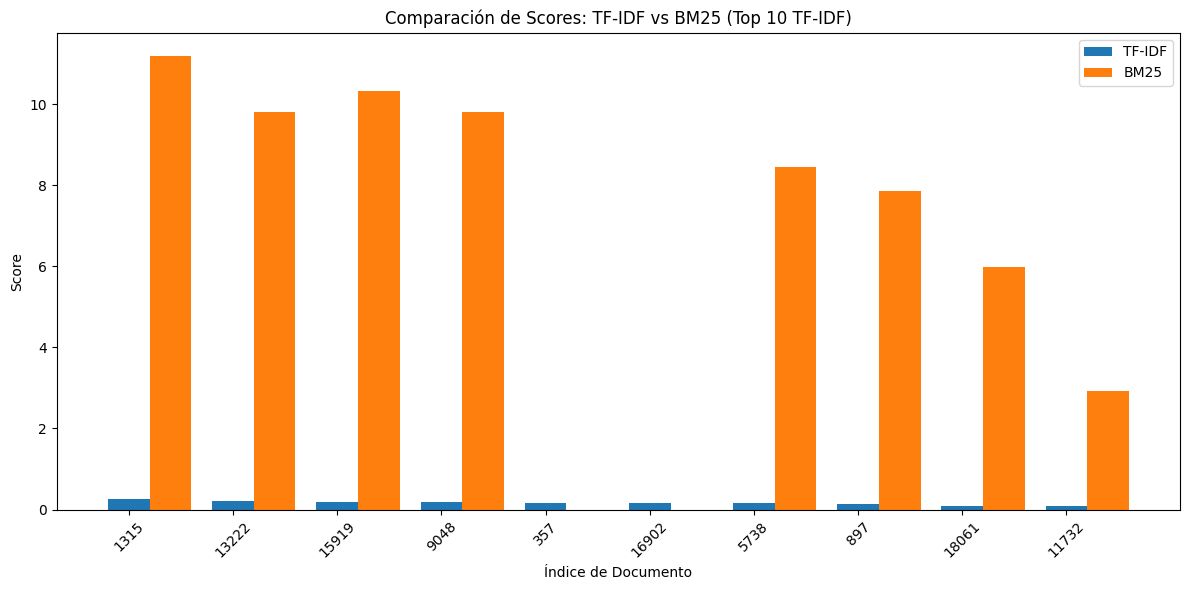

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Selecciona los mismos documentos top_n para ambos modelos (por ejemplo, los top 10 de TF-IDF)
top_n = 10
top_tfidf_indices = ranking_indices[:top_n]

# Prepara los datos para el gráfico
tfidf_scores_top = similitudes[top_tfidf_indices]
bm25_scores_top = bm25_scores[top_tfidf_indices]  # BM25 para los mismos docs que top TF-IDF

# Gráfico de barras comparativo
plt.figure(figsize=(12,6))
plt.bar(range(top_n), tfidf_scores_top, width=0.4, label='TF-IDF', align='center')
plt.bar([i + 0.4 for i in range(top_n)], bm25_scores_top, width=0.4, label='BM25', align='center')
plt.xticks(range(top_n), top_tfidf_indices, rotation=45)
plt.xlabel('Índice de Documento')
plt.ylabel('Score')
plt.title('Comparación de Scores: TF-IDF vs BM25 (Top 10 TF-IDF)')
plt.legend()
plt.tight_layout()
plt.show()


## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [20]:
# Define la consulta y los documentos relevantes (ajusta los índices según tu criterio)
consulta = ["chicken"]
relevantes = {1315, 15919, 13222}  # <-- Cambia estos índices por los que consideres relevantes

In [21]:
def precision_at_k(ranking, relevantes, k=3):
    top_k = ranking[:k]
    relevantes_en_top_k = sum(1 for idx in top_k if idx in relevantes)
    return relevantes_en_top_k / k

def average_precision(ranking, relevantes, k=10):
    hits = 0
    sum_precisions = 0
    for i, idx in enumerate(ranking[:k], 1):
        if idx in relevantes:
            hits += 1
            sum_precisions += hits / i
    return sum_precisions / min(len(relevantes), k) if relevantes else 0

# Rankings de TF-IDF y BM25
ranking_tfidf = ranking_indices
ranking_bm25 = ranking_bm25

# Precision@3
p3_tfidf = precision_at_k(ranking_tfidf, relevantes, k=3)
p3_bm25 = precision_at_k(ranking_bm25, relevantes, k=3)

# MAP@10
map_tfidf = average_precision(ranking_tfidf, relevantes, k=10)
map_bm25 = average_precision(ranking_bm25, relevantes, k=10)

print(f"TF-IDF Precision@3: {p3_tfidf:.2f}")
print(f"BM25 Precision@3: {p3_bm25:.2f}")
print(f"TF-IDF MAP@10: {map_tfidf:.2f}")
print(f"BM25 MAP@10: {map_bm25:.2f}")

TF-IDF Precision@3: 1.00
BM25 Precision@3: 1.00
TF-IDF MAP@10: 1.00
BM25 MAP@10: 1.00


Todos los documentos relevantes que se definen como relevantes = {1315, 15919, 13222} están dentro de los primeros 3 lugares del ranking (para Precision@3) y dentro de los primeros 10 lugares (para MAP@10) tanto en TF-IDF como en BM25.
Es decir, los modelos están recuperando perfectamente los documentos relevantes en las primeras posiciones como se puede ver en los literales anteriores.